<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
#импортируем необходимые для работы библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import catboost
import lightgbm

In [ ]:
#считаем датасет и сохраним его в переменной

pth1 = '/datasets/taxi.csv'
pth2 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Ошибка')

In [ ]:
data.head() #выведем первые 5 строк получившегося датафрейма

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
#проверим, в хронологическом ли порядке расположены даты и время
data.index.is_monotonic

True

Данные расположены в хронологическом порядке. Произведём ресемплирование по одному часу.

In [ ]:
data = data.sort_index()
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:** мы считали и изучили данные, убедились, что они расположены в хронологическом порядке, и провели ресемплирование по одному часу.

## Анализ

Посмотрим, за какой период у нас есть данные.

In [ ]:
print('Период, за который есть данные:', data.index.min(), '-', data.index.max())

Период, за который есть данные: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


Построим график временного ряда, а также графики тренда, сезонности и остатка за весь доступный период.

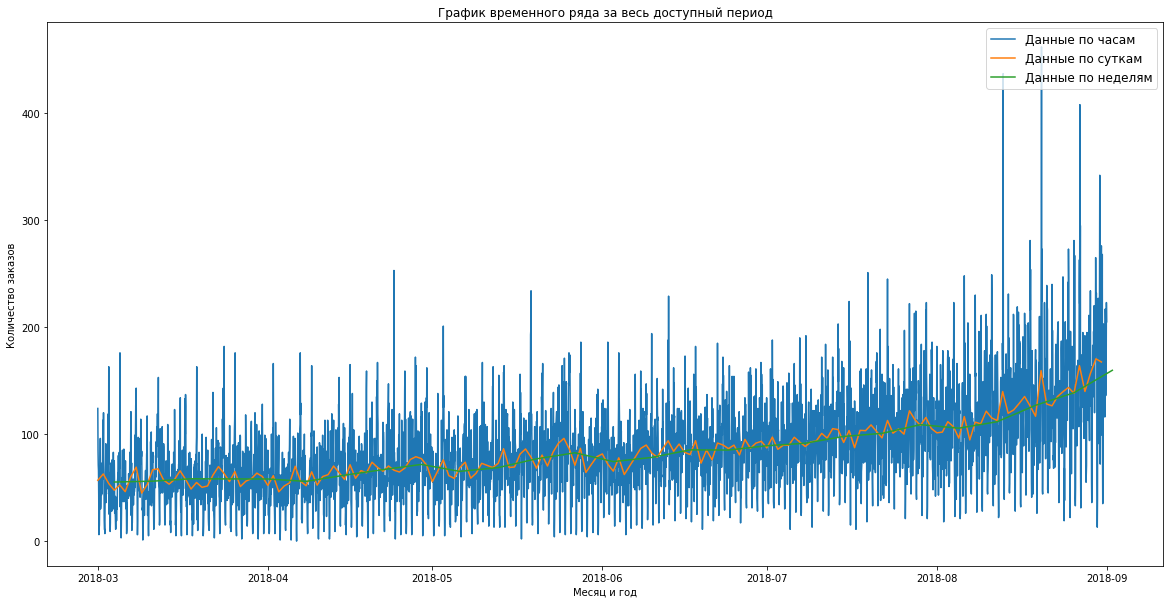

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data, label='Данные по часам')
ax.plot(data.resample('1D').mean(), label='Данные по суткам')
ax.plot(data.resample('1W').mean(), label='Данные по неделям')
plt.title('График временного ряда за весь доступный период')
plt.xlabel('Месяц и год')
plt.ylabel('Количество заказов')
legend = ax.legend(loc='upper right', fontsize= 12)

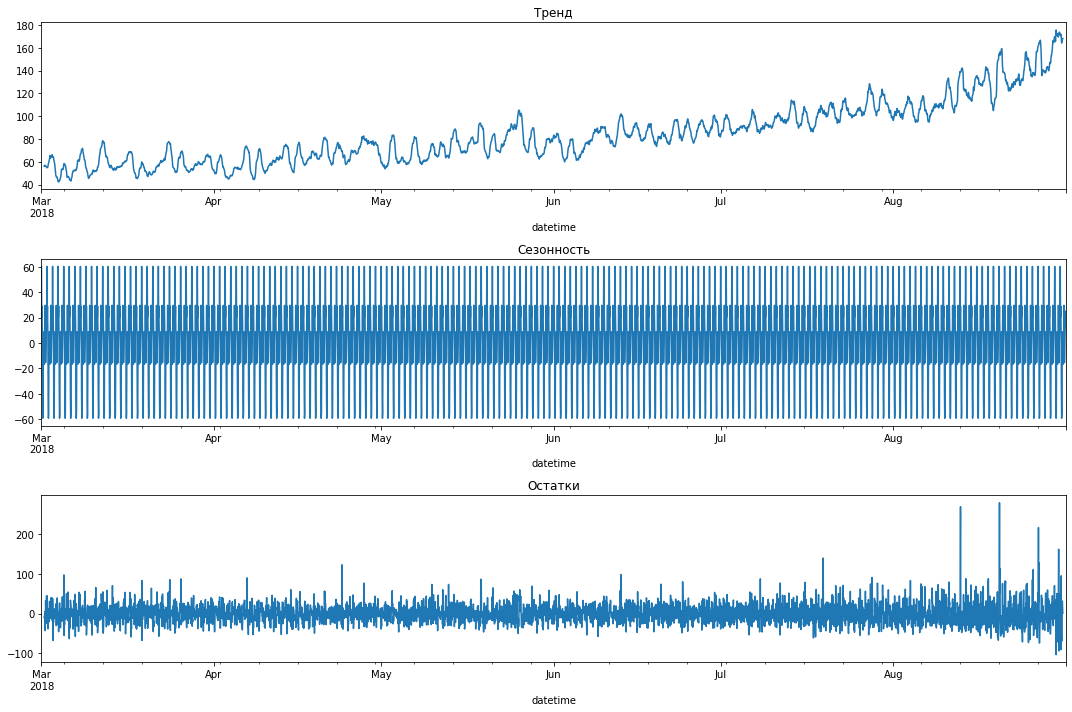

In [ ]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Мы видим, что к лету по сравнению с весной количество заказов растёт - это тренд. Самое большое количество заказов было сделано в августе. Так как мы рассматриваем данные о заказах такси в аэропортах, можно предположить, что это связано с бОльшим количеством отпусков и, соотвественно, бОльшим количеством отдыхающих, которые куда-то или откуда-то летят.

Чтобы посмотреть на наличие сезонности, построим такой же набор графиков для небольшого отрезка времени - первые 15 дней августа.

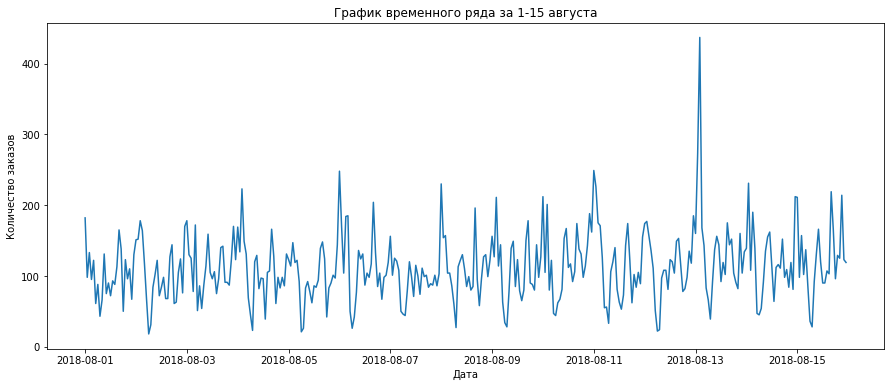

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(data['2018-08-01':'2018-08-15'])
plt.title('График временного ряда за 1-15 августа')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

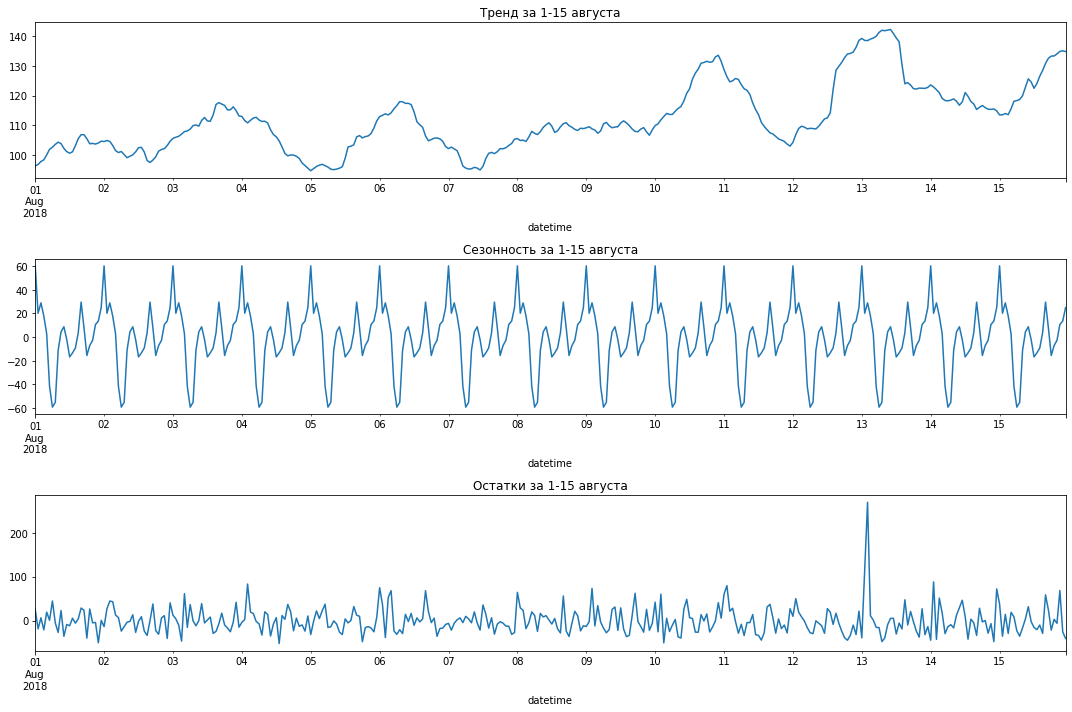

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Тренд за 1-15 августа')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Сезонность за 1-15 августа')
plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Остатки за 1-15 августа')
plt.tight_layout()

Чтобы выявить недельную сезонность, сделаем ресемплинг данных по суткам и также построим графики тренда, сезонности и остатка.

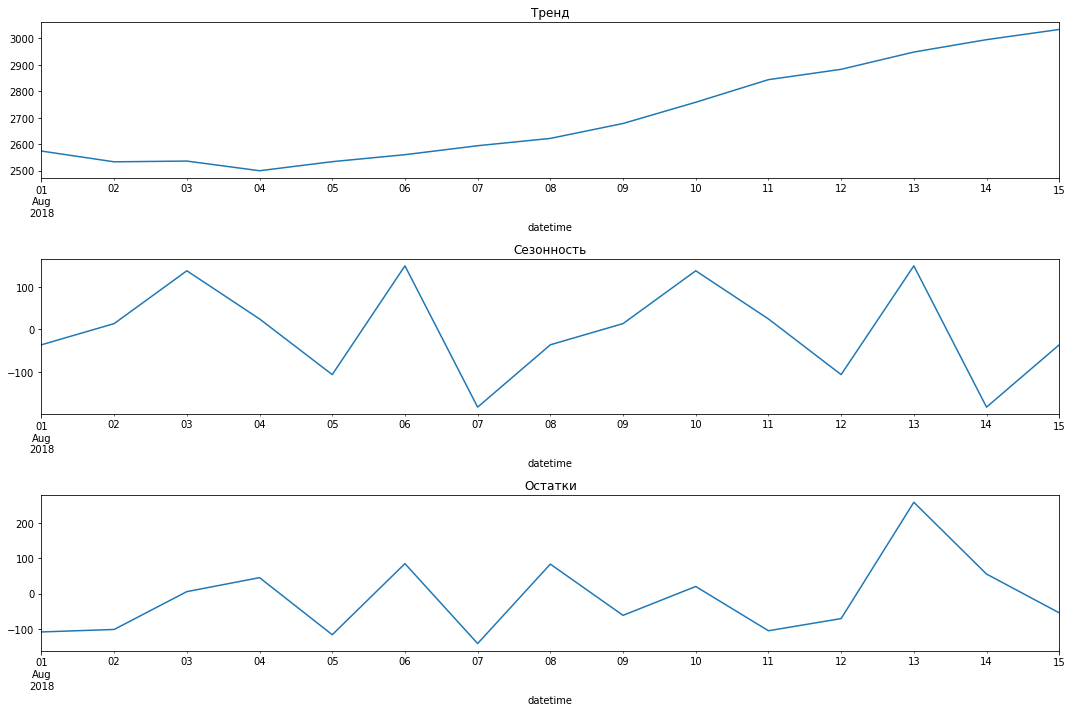

In [ ]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed_day.trend['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed_day.seasonal['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed_day.resid['2018-08-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

В основном пик заказов приходится на вечернее время, ночью заказов почти нет. Также наблюдается большее количество заказов в выходные дни.

**Вывод:** мы построили график временного ряда, а также графики тренда, сезонности и остатка за весь доступный период и за первые 15 дней августа и выяснили, что:
- к лету по сравнению с весной количество заказов растёт - это тренд
- самое большое количество заказов было сделано в августе. Так как мы рассматриваем данные о заказах такси в аэропортах, можно предположить, что это связано с бОльшим количеством отпусков и, соотвественно, бОльшим количеством отдыхающих, которые куда-то или откуда-то летят
- в основном пик заказов приходится на вечернее время, ночью заказов почти нет
- наблюдается большее количество заказов в выходные дни

## Обучение

### Создание признаков

Создадим признаки для горизонта прогнозирования в один шаг: календарные, отстающие значения, скользящее среднее.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return(data)

Зададим 24 (сутки) в качестве значения для отстающих значений и 168 (неделя) в качестве размера окна скользящего среднего, чтобы сгладить всплески.

In [ ]:
data = make_features(data, 24, 168)
data.tail()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,154.297619
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,154.434524
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,154.285714
2018-08-31 22:00:00,223,22,4,159.0,154.0,136.0,207.0,217.0,197.0,116.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,154.244048
2018-08-31 23:00:00,205,23,4,223.0,159.0,154.0,136.0,207.0,217.0,197.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,154.130952


### Разделение на выборки

In [ ]:
#по условиям исследования размер тестовой выборки должен составлять 10%
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [ ]:
#проверим, что тестовая выборка составлена из данных в конце доступного нам промежутка времени
print('Обучающая выборка:', train.index.min(), '-', train.index.max())
print('Тестовая выборка:', test.index.min(), '-', test.index.max())

Обучающая выборка: 2018-03-08 00:00:00 - 2018-08-13 13:00:00
Тестовая выборка: 2018-08-13 14:00:00 - 2018-08-31 23:00:00


Cпрогнозируем наш временной ряд с помощью предыдущего значения.

In [ ]:
pred_previous = np.ones(test.shape)*test.shift(fill_value = train.iloc[-1]['num_orders'])
print("RMSE:", np.sqrt(mean_squared_error(test, pred_previous)))

RMSE: 56.26714445478465


In [ ]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

Данные готовы к обучению. Обучим три модели: линейную регрессию, CatBoost и LightGBM. Выбирать лучшие значения гиперпараметров будем с помощью GridSearchCV. По условиям исследования для оценки качества моделей необходимо использовать метрику RMSE.

### Линейная регрессия

In [ ]:
#масштабируем данные для линейной регрессии
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
features_train_linear = features_train.copy()
features_test_linear = features_test.copy()

scaler = StandardScaler()

features_train_linear[num_features] = scaler.fit_transform(features_train_linear[num_features])
features_test_linear[num_features] = scaler.transform(features_test_linear[num_features])
features_test_linear.head()

,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,0.363909,-1.512443,1.025343,0.326894,1.671969,1.983858,1.493175,0.302670,-1.043140,-0.344213,...,1.026673,1.474748,0.501559,0.081135,-0.024007,0.949309,1.949916,1.845426,0.661506,2.133102
2018-08-13 15:00:00,0.508409,-1.512443,0.585767,1.024915,0.327235,1.673375,1.984880,1.493088,0.302626,-1.042919,...,2.789769,1.027424,1.474861,0.501840,0.081169,-0.023671,0.950414,1.950667,1.845485,2.134501
2018-08-13 16:00:00,0.652910,-1.512443,2.473359,0.585420,1.025462,0.327948,1.674330,1.984782,1.493111,0.302737,...,2.131897,2.790407,1.027668,1.474723,0.501873,0.081516,-0.022785,0.950879,1.950728,2.154781
2018-08-13 17:00:00,0.797410,-1.512443,1.671779,2.472663,0.585838,1.026535,0.328610,1.674238,1.984834,1.493125,...,5.105476,2.132577,2.790133,1.027723,1.474753,0.502264,0.082426,-0.022598,0.950923,2.133802
2018-08-13 18:00:00,0.941911,-1.512443,1.878638,1.671231,2.473637,0.586684,1.027349,0.328549,1.674272,1.984807,...,9.421112,5.105966,2.132497,2.789429,1.027754,1.475244,0.503269,0.082643,-0.022571,2.140445


In [ ]:
model_lr = LinearRegression()

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
param_grid_lr = {}
grid = GridSearchCV(model_lr, param_grid_lr, cv=tscv, scoring='neg_root_mean_squared_error', verbose=False)
grid.fit(features_train_linear, target_train)
print("RMSE лучшей модели линейной регрессии:", -grid.best_score_)

RMSE лучшей модели линейной регрессии: 27.07412984777809


### CatBoost

In [ ]:
model_cb = catboost.CatBoostRegressor(random_state=12345)

In [ ]:
#подберём гиперпараметры

param_grid_cb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 10],
    'iterations': [30, 50, 100]
}

grid = GridSearchCV(model_cb, param_grid_cb, cv=tscv, scoring='neg_root_mean_squared_error', verbose=False)
grid.fit(features_train, target_train)
print('Лучшие гиперпараметры:', grid.best_params_)
print("RMSE лучшей модели CatBoost:",  -grid.best_score_)

0:	learn: 29.4265745	total: 48.7ms	remaining: 1.41s
1:	learn: 29.3174261	total: 50.7ms	remaining: 710ms
2:	learn: 29.1934908	total: 52.2ms	remaining: 470ms
3:	learn: 29.0626041	total: 53.7ms	remaining: 349ms
4:	learn: 28.9425558	total: 55.2ms	remaining: 276ms
5:	learn: 28.8239118	total: 56.7ms	remaining: 227ms
6:	learn: 28.7115934	total: 58ms	remaining: 190ms
7:	learn: 28.5924915	total: 59.4ms	remaining: 163ms
8:	learn: 28.4687541	total: 60.8ms	remaining: 142ms
9:	learn: 28.3477249	total: 62.2ms	remaining: 124ms
10:	learn: 28.2400868	total: 63.5ms	remaining: 110ms
11:	learn: 28.1360968	total: 64.8ms	remaining: 97.3ms
12:	learn: 28.0399079	total: 66.4ms	remaining: 86.8ms
13:	learn: 27.9222092	total: 67.8ms	remaining: 77.4ms
14:	learn: 27.8002699	total: 69.2ms	remaining: 69.2ms
15:	learn: 27.7007409	total: 70.7ms	remaining: 61.9ms
16:	learn: 27.5929633	total: 72.1ms	remaining: 55.2ms
17:	learn: 27.4895524	total: 73.7ms	remaining: 49.1ms
18:	learn: 27.3654724	total: 75.2ms	remaining: 43.5

### LightGBM

In [ ]:
model_lgbm = lightgbm.LGBMRegressor(random_state=12345)

In [ ]:
#подберём гиперпараметры

param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 10]
}

grid = GridSearchCV(model_lgbm, param_grid_lgbm, cv=tscv, scoring='neg_root_mean_squared_error', verbose=False)
grid.fit(features_train, target_train)
print('Лучшие гиперпараметры:', grid.best_params_)
print("RMSE лучшей модели LightGBM:",  -grid.best_score_)

Лучшие гиперпараметры: {'learning_rate': 0.05, 'max_depth': 6}
RMSE лучшей модели LightGBM: 24.90601682744629


**Вывод:** на этом этапе мы:
- создали признаки для горизонта прогнозирования в один шаг: календарные, отстающие значения, скользящее среднее
- разделили данные на обучающую и тестовую выборки. Размер тестовой выборки составляет 0,1
- спрогнозировали наш временной ряд с помощью предыдущего значения и получили RMSE равное 56.26714445478465
- далее мы обучили три модели: линейную регрессию, CatBoost и LightGBM и получили следующие значения RMSE:
    - RMSE лучшей модели линейной регрессии: 27.07412984777809
    - RMSE лучшей модели CatBoost с гиперпараметрами depth=6, iterations=100, learning_rate=0.1: 25.020161677530396
    - RMSE лучшей модели LightGBM с гиперпараметрами learning_rate=0.05, max_depth=6: 24.90601682744629
    
Поскольку самое низкое значение RMSE оказалось у LightGBM, проверим её на тестовой выборке.

## Тестирование

Обучим модель LightGBM с подобранными гиперпараметрами, сделаем предсказание на тестовой выборке и посчитаем RMSE.

In [ ]:
predictions_lgbm_test = grid.best_estimator_.predict(features_test)
print("RMSE LightGBM на тестовой выборке:",  mean_squared_error(target_test, predictions_lgbm_test) ** 0.5)

RMSE LightGBM на тестовой выборке: 40.89802331458129


По условиям исследования RMSE на тестовой выборке должно быть не больше 48 - в нашем случае оно не превышает пороговое и составляет 40.89802331458129. Мы также знаем, что наша модель проходит проверку на адекватность: ранее мы прогнозировали наш временной ряд с помощью предыдущего значения и получили RMSE равное 56.26714445478465.

Построим график, на котором отобразим реальное количество заказов и наши предсказания.

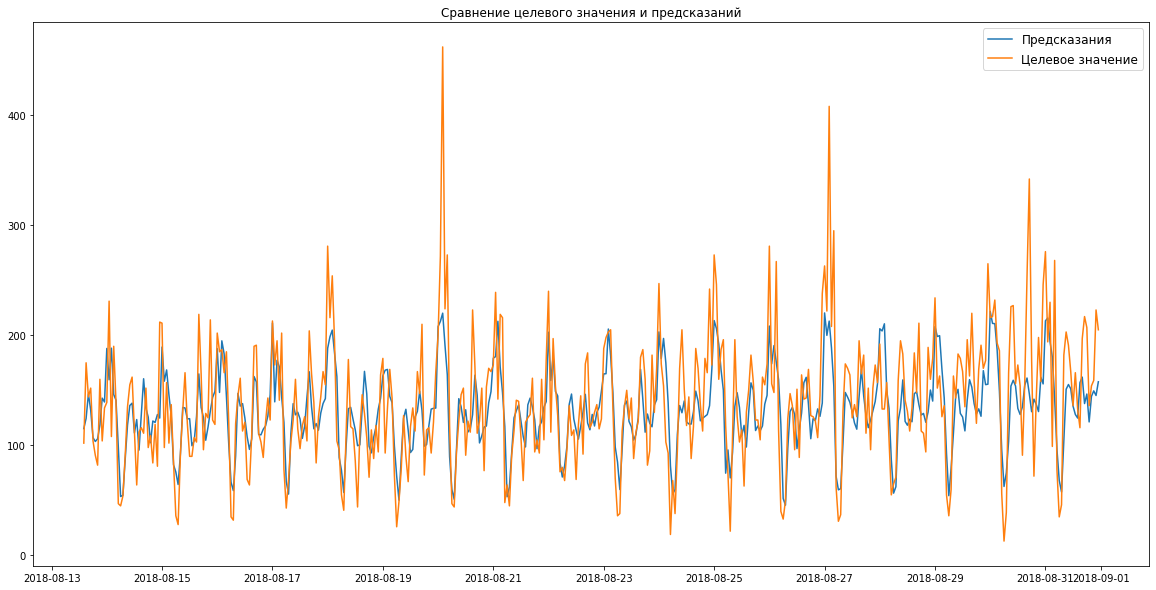

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(pd.Series(predictions_lgbm_test, index = target_test.index), label='Предсказания')
ax.plot(target_test, label='Целевое значение')
plt.title('Сравнение целевого значения и предсказаний')
legend = ax.legend(loc='upper right', fontsize= 12)

Как мы видим, предсказания близки к целевому значению, но модель чуть хуже определяет резкие всплески, так как мы брали большое окно скользящего среднего.

## Вывод

Мы провели исследование для компании «Чётенькое такси» на основе исторических данные о заказах такси в аэропортах. Цель исследования - построить модель, которая спрогнозирует количество заказов такси на следующий час.

1) Мы считали и изучили данные, убедились, что они расположены в хронологическом порядке, и провели ресемплирование по одному часу.

2) Построили график временного ряда, а также графики тренда, сезонности и остатка за весь доступный период и за первые 15 дней августа и выяснили, что:

- к лету по сравнению с весной количество заказов растёт - это тренд
- самое большое количество заказов было сделано в августе. Так как мы рассматриваем данные о заказах такси в аэропортах, можно предположить, что это связано с бОльшим количеством отпусков и, соотвественно, бОльшим количеством отдыхающих, которые куда-то или откуда-то летят
- в основном пик заказов приходится на вечернее время, ночью заказов почти нет
- наблюдается большее количество заказов в выходные дни

3) Далее мы:

- создали признаки для горизонта прогнозирования в один шаг: календарные, отстающие значения, скользящее среднее
- разделили данные на обучающую и тестовую выборки. Размер тестовой выборки составляет 0,1
- спрогнозировали наш временной ряд с помощью предыдущего значения и получили RMSE равное 56.26714445478465
- далее мы обучили три модели: линейную регрессию, CatBoost и LightGBM и получили следующие значения RMSE:
    - RMSE лучшей модели линейной регрессии: 27.07412984777809
    - RMSE лучшей модели CatBoost с гиперпараметрами depth=6, iterations=100, learning_rate=0.1: 25.020161677530396
    - RMSE лучшей модели LightGBM с гиперпараметрами learning_rate=0.05, max_depth=6: 24.90601682744629

Поскольку самое низкое значение RMSE оказалось у LightGBM, мы выбрали её для проверки на тестовой выборке.
   
4) По условиям исследования RMSE на тестовой выборке должно быть не больше 48 - в нашем случае оно не превышает пороговое и составляет 40.89802331458129. Мы также знаем, что наша модель проходит проверку на адекватность: ранее мы прогнозировали наш временной ряд с помощью предыдущего значения и получили RMSE равное 56.26714445478465. Также мы построили график, на котором отобразили реальное количество заказов и наши предсказания и выяснили, что предсказания близки к целевому значению, но модель чуть хуже определяет резкие всплески, так как мы брали большое окно скользящего среднего.

Таким образом, **стоит выбрать модель LightGBM с гиперпараметрами learning_rate=0.05, max_depth=6.**